* Preliminary explore of the data from https://www.kaggle.com/c/dstl-satellite-imagery-feature-detection/data
* images are not geotiffs so use skimage - rasterio/gdal is not available on kaggle
* 450 1km x 1km satellite images in both 3-band and 16-band formats
* In this dataset that we provide, we create a set of geo-coordinates that are **in the range of x = [0,1] and y = [-1,0]**. These coordinates are transformed such that **we obscure the location of where the satellite images are taken from**. The images are from the same region on Earth.
* A very useful reference is https://github.com/rogerxujiang/dstl_unet although he has used slightly different packages than I choose here
* A fair amount of data engineering is required, e.g. to export the pixel wise masked data https://www.kaggle.com/visoft/export-pixel-wise-mask

Imagery details
* Sensor : WorldView 3
* Panchromatic: 450-800 nm @ 0.31m 
* 8 Multispectral: (red, red edge, coastal, blue, green, yellow, near-IR1 and near-IR2) 400 nm - 1040 nm @  1.24 m
* 8 SWIR: 1195 nm - 2365 nm @ 7.5m

Dynamic Range
* Panchromatic and multispectral : 11-bits per pixel
* SWIR : 14-bits per pixel

Class labels
```
1 Buildings - large building, residential, non-residential, fuel storage facility, fortified building

2 Misc. Manmade structures 

3 Road 

4 Track - poor/dirt/cart track, footpath/trail

5 Trees - woodland, hedgerows, groups of trees, standalone trees

6 Crops - contour ploughing/cropland, grain (wheat) crops, row (potatoes, turnips) crops

7 Waterway 

8 Standing water

9 Vehicle Large - large vehicle (e.g. lorry, truck,bus), logistics vehicle

10 Vehicle Small - small vehicle (car, van), motorbike
```

In [1]:
import os
import glob
import geoplot
import geopandas as gpd
import numpy as np
import pandas as pd
from skimage import io
from matplotlib import pyplot as plt
%matplotlib inline

fig_width, fig_height = 10, 10

In [2]:
data_dir = '/Users/robincole/Documents/kaggle/dstl/'

In [3]:
glob.glob(data_dir + '*')

['/Users/robincole/Documents/kaggle/dstl/grid_sizes.csv',
 '/Users/robincole/Documents/kaggle/dstl/train_wkt_v4.csv',
 '/Users/robincole/Documents/kaggle/dstl/sixteen_band',
 '/Users/robincole/Documents/kaggle/dstl/train_geojson_v3',
 '/Users/robincole/Documents/kaggle/dstl/sample_submission.csv',
 '/Users/robincole/Documents/kaggle/dstl/three_band']

## Images in RGB
RGB in `three_band`

In [4]:
three_band = glob.glob(data_dir + 'three_band/*', recursive=True)
print(len(three_band))
three_band[:3]

450


['/Users/robincole/Documents/kaggle/dstl/three_band/6180_4_3.tif',
 '/Users/robincole/Documents/kaggle/dstl/three_band/6130_0_4.tif',
 '/Users/robincole/Documents/kaggle/dstl/three_band/6120_0_4.tif']

There are 450 three band images, lets show one

In [5]:
# image_file = three_band[0]

In [6]:
tile = '6120_2_2'
image_file=f'/Users/robincole/Documents/kaggle/dstl/three_band/{tile}.tif'

In [7]:
im = io.imread(image_file)

In [8]:
im.shape

(3348, 3403, 3)

In [9]:
## Take the convenience function from https://github.com/rogerxujiang/dstl_unet/blob/master/utils/data_utils.py

def scale_percentile(img):
    '''
    Scale an image's 1 - 99 percentiles into 0 - 1 for display
    :param img:
    :return:
    '''
    orig_shape = img.shape
    if len(orig_shape) == 3:
        img = np.reshape(img,
                         [orig_shape[0] * orig_shape[1], orig_shape[2]]
                         ).astype(np.float32)
    elif len(orig_shape) == 2:
        img = np.reshape(img, [orig_shape[0] * orig_shape[1]]).astype(np.float32)
    mins = np.percentile(img, 1, axis = 0)
    maxs = np.percentile(img, 99, axis = 0) - mins

    img = (img - mins) / maxs

    img.clip(0., 1.)
    img = np.reshape(img, orig_shape)

    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


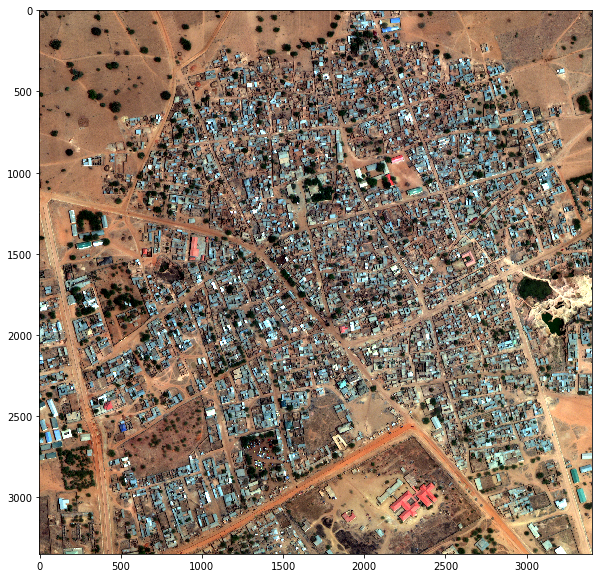

In [10]:
f, ax = plt.subplots(1, 1, figsize=(fig_width, fig_height))
ax.imshow(scale_percentile(im));

There undoubtably is an skimage routine to perform scaling..

## 16 Band images
The full dataset is in `sixteen_band/` and I expect these will be much more useful than just RGB

The 16 bands are distributed in the images with `file name = {ImageId}_{A/M/P}.tif`

In [11]:
sixteen_band = glob.glob(data_dir + 'sixteen_band/*', recursive=True)
print(len(sixteen_band))
sixteen_band[:6]

1350


['/Users/robincole/Documents/kaggle/dstl/sixteen_band/6080_0_3_P.tif',
 '/Users/robincole/Documents/kaggle/dstl/sixteen_band/6020_4_4_M.tif',
 '/Users/robincole/Documents/kaggle/dstl/sixteen_band/6020_0_0_A.tif',
 '/Users/robincole/Documents/kaggle/dstl/sixteen_band/6120_0_3_M.tif',
 '/Users/robincole/Documents/kaggle/dstl/sixteen_band/6010_3_3_M.tif',
 '/Users/robincole/Documents/kaggle/dstl/sixteen_band/6180_4_4_P.tif']

We have images with `P, M, A` suffixes corresponding to A band (8 channels) + M band (8 channels) + P band (1 channel)

Lets get all the images for our interesting tile

In [12]:
images_6120_2_2 = glob.glob(data_dir + 'sixteen_band/6120_2_2*', recursive=True)

In [13]:
images_6120_2_2

['/Users/robincole/Documents/kaggle/dstl/sixteen_band/6120_2_2_M.tif',
 '/Users/robincole/Documents/kaggle/dstl/sixteen_band/6120_2_2_A.tif',
 '/Users/robincole/Documents/kaggle/dstl/sixteen_band/6120_2_2_P.tif']

Plot the swir (A) file

In [14]:
image_file = images_6120_2_2[1]
image_file

'/Users/robincole/Documents/kaggle/dstl/sixteen_band/6120_2_2_A.tif'

In [15]:
im = io.imread(image_file)
im.shape

(8, 134, 137)

As expected the resolution is far lower

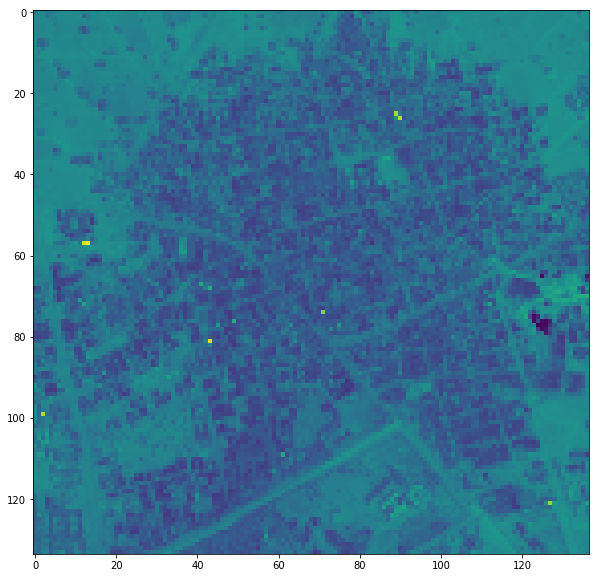

In [16]:
f, ax = plt.subplots(1, 1, figsize=(fig_width, fig_height))
ax.imshow(im[0,:,:]);

## Explore tabular data

### Grid sizes
First `grid_sizes` - the X,Y coordinate extents of the images
* ImageId - ID of the image
* Xmax - maximum X coordinate for the image
* Ymin - minimum Y coordinate for the image

In [17]:
grid_sizes = pd.read_csv(data_dir + 'grid_sizes.csv')

In [18]:
grid_sizes.shape

(450, 3)

In [19]:
grid_sizes.head()

,Unnamed: 0,Xmax,Ymin
0,6120_2_4,0.009180,-0.00904
1,6120_2_3,0.009169,-0.00904
2,6120_2_2,0.009188,-0.00904
3,6120_2_1,0.009188,-0.00904
4,6120_2_0,0.009188,-0.00904


### Training labels
`train_wkt.csv` - the [WKT format](https://en.wikipedia.org/wiki/Well-known_text) of all the training labels
* ImageId - ID of the image
* ClassType - type of objects (1-10)
* MultipolygonWKT - the labeled area, which is multipolygon geometry represented in WKT format 

In [20]:
train_wkt = pd.read_csv(data_dir + 'train_wkt_v4.csv')

In [21]:
train_wkt.shape

(250, 3)

In [22]:
train_wkt.head(3)

,ImageId,ClassType,MultipolygonWKT
0,6040_2_2,1,MULTIPOLYGON EMPTY
1,6040_2_2,2,MULTIPOLYGON EMPTY
2,6040_2_2,3,MULTIPOLYGON EMPTY


In [23]:
train_wkt.iloc[100]

ImageId                                                     6110_1_2
ClassType                                                          1
MultipolygonWKT    MULTIPOLYGON (((5.99993550571e-05 -0.009031902...
Name: 100, dtype: object

In [24]:
print(len(train_wkt['ImageId'].unique()))
train_wkt['ImageId'].unique()

25


array(['6040_2_2', '6120_2_2', '6120_2_0', '6090_2_0', '6040_1_3',
       '6040_1_0', '6100_1_3', '6010_4_2', '6110_4_0', '6140_3_1',
       '6110_1_2', '6100_2_3', '6150_2_3', '6160_2_1', '6140_1_2',
       '6110_3_1', '6010_4_4', '6170_2_4', '6170_4_1', '6170_0_4',
       '6060_2_3', '6070_2_3', '6010_1_2', '6040_4_4', '6100_2_2'],
      dtype=object)

Hmm there are only 25 training images..

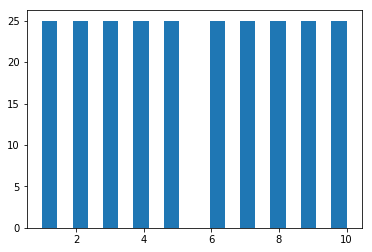

In [25]:
plt.hist(train_wkt['ClassType'], bins=20);

Appears we have uniform distribution of classes

## GeoJSON
As an alternative to wtk we have the same data in GeoJSON. We can view geojson files at http://geojson.io/ but note that these files are not geolocated.

Note that competition submission will be in the WKT format. 

In [26]:
print(len(glob.glob(data_dir + 'train_geojson_v3/*')))
train_geojson = glob.glob(data_dir + 'train_geojson_v3/*/*', recursive=True)
print(len(train_geojson))
train_geojson[:3]

25
299


['/Users/robincole/Documents/kaggle/dstl/train_geojson_v3/6110_4_0/001_MM_L5_MISC_SMALL_STRUCTURE.geojson',
 '/Users/robincole/Documents/kaggle/dstl/train_geojson_v3/6110_4_0/007_AGR_L7_FARM_ANIMALS_IN_FIELD.geojson',
 '/Users/robincole/Documents/kaggle/dstl/train_geojson_v3/6110_4_0/006_VEG_L2_SCRUBLAND.geojson']

There are 25 directories of geojson and approximately 12 files per directory. Lets use geopandas to load a single file

In [27]:
geo_file = train_geojson[0]
geo_file

'/Users/robincole/Documents/kaggle/dstl/train_geojson_v3/6110_4_0/001_MM_L5_MISC_SMALL_STRUCTURE.geojson'

In [28]:
geo_df = gpd.read_file(geo_file)
print(geo_df.shape)
geo_df.head()

(512, 6)


,ID,ACAD_LAYER,TILE_NAME,SUPERCLASS,LABEL,geometry
0,9a96a383-3454-406a-9eab-e9f9d5b9c711,001_MM_L5_MISC_SMALL_STRUCTURE,6110_4_0,MAN-MADE,MISC_SMALL_MANMADE_STRUCTURE,"POLYGON ((0.007833 -0.000674, 0.007826 -0.0006..."
1,cf3cf024-ca06-4f64-9825-b8d7c5cd458f,001_MM_L5_MISC_SMALL_STRUCTURE,6110_4_0,MAN-MADE,MISC_SMALL_MANMADE_STRUCTURE,"POLYGON ((0.000415 -0.001338, 0.00043 -0.00135..."
2,6c2fb56b-810e-4e73-a3f7-feb9ebb7dcd3,001_MM_L5_MISC_SMALL_STRUCTURE,6110_4_0,MAN-MADE,MISC_SMALL_MANMADE_STRUCTURE,"POLYGON ((0.008026999999999999 -0.00187, 0.008..."
3,4a6bc1ee-ae72-44c4-858a-6fba5f1b1185,001_MM_L5_MISC_SMALL_STRUCTURE,6110_4_0,MAN-MADE,MISC_SMALL_MANMADE_STRUCTURE,POLYGON ((0.00832047826086956 -0.0010141739130...
4,23360ffe-8e00-490b-953a-5edab56bc0ef,001_MM_L5_MISC_SMALL_STRUCTURE,6110_4_0,MAN-MADE,MISC_SMALL_MANMADE_STRUCTURE,"POLYGON ((0.008721 -0.001011, 0.00885 -0.00099..."


In [29]:
geo_df['LABEL'].unique()

array(['MISC_SMALL_MANMADE_STRUCTURE'], dtype=object)

In [30]:
len(geo_df['TILE_NAME'].unique())

1

In [31]:
geo_df.iloc[0]

ID                         9a96a383-3454-406a-9eab-e9f9d5b9c711
ACAD_LAYER                       001_MM_L5_MISC_SMALL_STRUCTURE
TILE_NAME                                              6110_4_0
SUPERCLASS                                             MAN-MADE
LABEL                              MISC_SMALL_MANMADE_STRUCTURE
geometry      POLYGON ((0.007833 -0.000674, 0.007826 -0.0006...
Name: 0, dtype: object

In [32]:
TILE_NAME = geo_df.iloc[0]['TILE_NAME']
TILE_NAME

'6110_4_0'

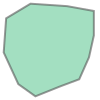

In [33]:
geo_df.iloc[0]['geometry']

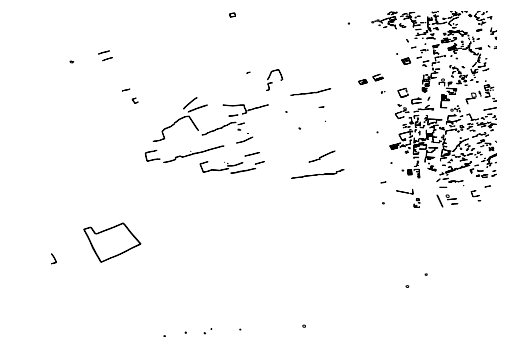

In [34]:
geoplot.polyplot(geo_df);

## View a single tile with features

In [35]:
TILE_NAME

'6110_4_0'

In [36]:
grid_sizes[grid_sizes['Unnamed: 0']==TILE_NAME]

,Unnamed: 0,Xmax,Ymin
282,6110_4_0,0.009169,-0.00904


In [37]:
tile_geojson = glob.glob(data_dir + f'train_geojson_v3/{TILE_NAME}/*', recursive=True)
tile_geojson

['/Users/robincole/Documents/kaggle/dstl/train_geojson_v3/6110_4_0/001_MM_L5_MISC_SMALL_STRUCTURE.geojson',
 '/Users/robincole/Documents/kaggle/dstl/train_geojson_v3/6110_4_0/007_AGR_L7_FARM_ANIMALS_IN_FIELD.geojson',
 '/Users/robincole/Documents/kaggle/dstl/train_geojson_v3/6110_4_0/006_VEG_L2_SCRUBLAND.geojson',
 '/Users/robincole/Documents/kaggle/dstl/train_geojson_v3/6110_4_0/002_TR_L4_POOR_DIRT_CART_TRACK.geojson',
 '/Users/robincole/Documents/kaggle/dstl/train_geojson_v3/6110_4_0/008_WTR_L2_STANDING_WATER.geojson',
 '/Users/robincole/Documents/kaggle/dstl/train_geojson_v3/6110_4_0/004_UPI_L5_PYLONS.geojson',
 '/Users/robincole/Documents/kaggle/dstl/train_geojson_v3/6110_4_0/003_VH_L4_LARGE_VEHICLE.geojson',
 '/Users/robincole/Documents/kaggle/dstl/train_geojson_v3/6110_4_0/002_TR_L3_GOOD_ROADS.geojson',
 '/Users/robincole/Documents/kaggle/dstl/train_geojson_v3/6110_4_0/006_VEG_L5_STANDALONE_TREES.geojson',
 '/Users/robincole/Documents/kaggle/dstl/train_geojson_v3/6110_4_0/001_MM_

(3348, 3396, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


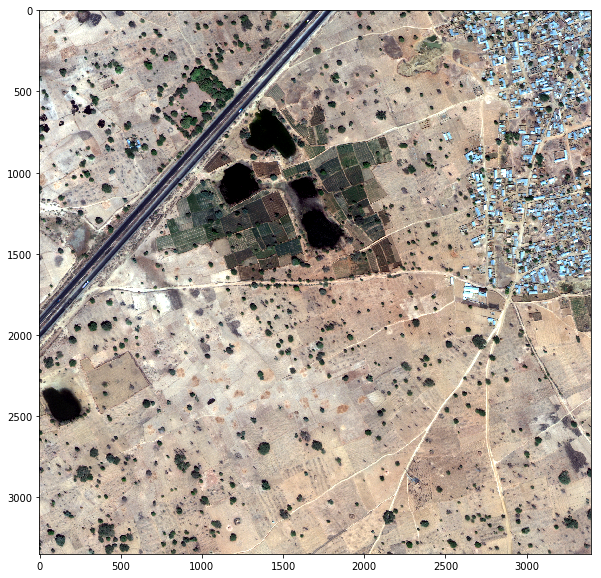

In [38]:
image_file = f'/Users/robincole/Documents/kaggle/dstl/three_band/{TILE_NAME}.tif'
im = io.imread(image_file)
print(im.shape)
f, ax = plt.subplots(1, 1, figsize=(fig_width, fig_height))
ax.imshow(scale_percentile(im))

We can see there are many small man-made structures in this image

### Sample submission

`sample_submission.csv` - a sample submission file in the correct format
* ImageId - ID of the image
* ClassType - type of objects (1-10)
* MultipolygonWKT - the labeled area, which is multipolygon geometry represented in WKT format

In [39]:
sample_submission = pd.read_csv(data_dir + 'sample_submission.csv')

In [40]:
sample_submission.head()

,ImageId,ClassType,MultipolygonWKT
0,6120_2_4,1,"POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399..."
1,6120_2_4,2,"POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399..."
2,6120_2_4,3,"POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399..."
3,6120_2_4,4,"POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399..."
4,6120_2_4,5,"POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399..."
